In [66]:
from typing import List, Tuple
import numpy as np
from qiskit import QuantumCircuit, BasicAer, transpile, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import StatePreparation, MCXGate
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

### Task 1

Given a positive integer and a list of prime numbers, look for the two prime numbers, that sum the positive number. Consider an appropriate number of qubits and explain why your proposal is valid for all kinds of numbers in case.

### Solution

We are going to assume that there are only prime numbers in the list, so no prime verification is needed after finding a pair of numbers in the list that sum the given integer. That means that we can focus in solving this: given a positive integer $n$ and a list of $m$ positive integers $a_0, \ldots, a_{m-1}$, find a pair of numbers in the list that sum $n$. The proposed solution of Task 1 is based on a general form of Grover's algorithm, called Amplitude Amplification ([Brassard et al., 2000](https://arxiv.org/pdf/quant-ph/0005055.pdf)), which allows us to find marked elements from a set $X$ of size $m$ starting with a superposition $\frac{1}{\sqrt{m}}\sum_{x\in X} |x\rangle$, where each $|x\rangle$ is an element of the canonical basis in a suitable Hilbert space of dimension greater than $m$ (i.e., those elements do not neccesarily form the complete basis). The initial superposition state we consider is of the form
$$
\frac{1}{\sqrt{L}} \sum_{i=0}^{m-2}\sum_{j=i+1}^{m-1} |i\rangle|j\rangle|a_{i}+a_{j}\rangle,
$$
where $L = \binom{m}{2} = m(m-1)/2$ is the number of different pairs of indices $(i,j)$ such that $i<j$. Then, we amplify those elements such that $a_{i}+a_{j} = n$ with the help of an oracle. Let us formalize this idea.



Let $N$ be the minimum number of bits neccesary to represent each integer in the list. Then each number $a$ can be written as $a = \sum_{i=0}^{N-1} x_i2^i$, where $x_i\in \{0,1\}$. Since
$$
a = \sum_{i=0}^{N-1} x_i2^i \leq \sum_{i=0}^{N-1} 2^i = 2^{N} - 1 \leq 2^N, 
$$
then $\log_2(a) \leq \log_2(2^N) = N$. Moreover, $N$ is the minimum integer that satisfies $a\leq 2^N$ for each $a$ in the list. Hence, $\lceil \log_2(a_{max}) \rceil = N$, where $a_{max}$ is the maximum integer in the list. Notice that if $a$ and $b$ are integers in the list, then $a+b$ is representable with $N+1$ bits. Let $N_m = \lceil \log_2(m-1) \rceil$ be the number of bits neccesary to represent each position index $i\in \{0, \ldots, m-1\}$ in the list. 

Consider $M=N+1+2N_m$ qubits. We use the first $N+1$ qubits to encode the sum of each pair of elements $|a_i + a_j\rangle$ and the next $2*N_m$ qubits to encode the pair of indices $|i\rangle |j\rangle$; each encoding is given by the binary representation of each integer. For example, if the list has 4 integers such and two of them are $a_0 = 2$ and $a_3=3$, then we encode the sum of $a_0$ and $a_1$ as
$$
|i\rangle|j\rangle|a_{i}+a_{j}\rangle = |00\rangle |11\rangle |101 \rangle = |0011101 \rangle.
$$
Since we use Amplitude Amplification for our solution, we need an oracle $O$ such that $O(|i\rangle |j\rangle |a_i+a_j\rangle) = -|i\rangle |j\rangle |a_i+a_j\rangle$ for those elements such that $a_i+a_j=n$. In our oracle implementation, we need $N+1$ ancilla qubits initialized as $|0\rangle$ and an extra qubit initialized in $|-\rangle$ for the [phase kickback trick](https://learn.qiskit.org/course/ch-gates/phase-kickback#kickback). In total, our quantum algorithm needs $2N+2N_m+3$ qubits.

The oracle is constructed as follows. Let $aux_0, \ldots, aux_{N}$ be the auxiliary quantum bits, and $x_0, \ldots, x_N$ the bits of $n$ (from less to more significant). First, we apply a $CX$ gate to flip $aux_0=|0\rangle$ (target qubit) whenever the first qubit of $|a_i+a_j\rangle$ (control qubit) is the same as $|x_0\rangle$. Then, we apply a $CCX$ gate to flip $aux_1=|0\rangle$ (target qubit) whenever the second qubit of $|a_i+a_j\rangle$ (control qubit) is the same as $|x_1\rangle$ and also $aux_0$ is equal $|1\rangle$. And so on, we flip the qubit $aux_k$ whenever the $k$-th qubit of $|a_i+a_j\rangle$ (control qubit) is the same as $|x_k\rangle$ and also $aux_{k-1}$ is equal to $|1\rangle$, $k=1, 2, \ldots, N$. Hence, $aux_N = |1\rangle$ whenever $a_i+a_j = n$ by construction (all bits of $a_i+a_j$ are the same as the bits of $n$). We then just apply a $CX$ gate with $aux_N$ as control qubit $|-\rangle$ as target qubit to make the phase kickback trick, obtaining our oracle $O$.

Let $A$ be the unitary operator such that 
$$
A|0\rangle^{\otimes M} = \frac{1}{\sqrt{L}} \sum_{0=i<j\leq m-1} |i\rangle|j\rangle|a_{i}+a_{j}\rangle,
$$
and $S_0 = 2|0\rangle^{\otimes M}\langle 0|^{\otimes M} - \mathbb{I}_M$. Then, the Amplitude Amplification algorithm is given by
$$
(AS_0A^\dag O)^t(A|0\rangle^{\otimes M}) = (AS_0A^\dag O)^t\left(\frac{1}{\sqrt{L}} \sum_{0=i<j\leq m-1} |i\rangle|j\rangle|a_{i}+a_{j}\rangle \right),
$$
for a suitable number of iterations $t$. When we measure that final state, we should obtain with high probability the elements $|i\rangle|j\rangle|a_{i}+a_{j}\rangle$ such that $a_i+a_j=n$. With the indices $i$, $j$ we can recover $a_i$ and $a_j$.

Below you can find the code.

In [206]:
# auxiliary functions

def binary_repr(n: int, m: int) -> str:
     # binary representation of a integer n as a bits string of length m
     return bin(n)[2:].zfill(m)

def bin_2_int(bin_repr: str) -> int:
     # given a binary string, returns the integer that it represents
     num_bits = len(bin_repr)
     n = 0
     for i in range(num_bits):
          if bin_repr[-1-i] == "1":
               n += 2**i
     
     return n

print(binary_repr(11, 5))
print(bin_2_int("1101"))

01011
13


In [200]:
def find_the_primes_numbers(n: int, list_numbers: List[int], iterations: int = 5) -> Tuple[QuantumCircuit, QuantumRegister, ClassicalRegister]:
     """
     Function that receives a positive integer n, a list of positive integers list_numbers (primes, if you want), and the number of iterations for the Amplitude Amplification. 
     It returns a quantum circuit, a quantum register and a classical register (in Qiskit).
     If you measure the quantum register (and save measurements on classical register), you will obtain with high probability a pair of integers in the list that sum n.
     """
     
     N = int(np.ceil(np.log2(max(list_numbers)))) # number of bits necessary to represent each number in the list
     # if n is not representable with N+1 bits, then there is no solution
     num_bits_n = int(np.ceil(np.log2(n)))
     
     if N+1 < num_bits_n:
          raise Exception("No solution: the given integer n is not representable with N+1, where N is the minimum number of bits neccesary to represent each integer in the list (the sum of two integers in the list needs only N+1 bits).")
     
     m = len(list_numbers) # number of elements in list
     N_m = int(np.ceil(np.log2(m-1))) # number of bits necessary to represent each index in the list (0, 1, ..., m-1)
     
     data_quantum = QuantumRegister(2*N_m + N+1, name="|i>|j>|sum>")
     classic_register = ClassicalRegister(2*N_m+N+1)
     aux_qreg = QuantumRegister(N+1, name="aux")
     phase_kickback = QuantumRegister(1, name="|->")
     
     qc = QuantumCircuit(data_quantum, aux_qreg, phase_kickback, classic_register)
     
     init_vec = np.zeros(2**(2*N_m + N+1)) # it will be the state vector for qubits in data_quantum quantum register
     
     for i in range(m):
          idx1 = binary_repr(i, N_m)
          for j in range(i+1, m):
               idx2 = binary_repr(j, N_m)
               sum_i_j = list_numbers[i] + list_numbers[j]
               sum_bin_repr = binary_repr(sum_i_j, N+1)
               
               state_string = idx1+idx2+sum_bin_repr # state |i>|j>|a_i + a_j> as binary string
               num_state = bin_2_int(state_string)
          
               init_vec[num_state] = 1
               
     
     init_vec = init_vec/np.linalg.norm(init_vec) # equal superposition of elements |i>|j>|a_i + a_j>
     init_state = Statevector(init_vec) 
     
     A = StatePreparation(init_state) # constructs unitary gate A such that A|0>^{(n)} is the equal superposition of elements |i>|j>|a_i+a_j>
     A_dag = StatePreparation(init_state, inverse=True) # inverse of A, i.e., A^\dag
     
     qc.append(A, data_quantum) # apply A gate to data_quantum register
     
     # create |-> in phase_kickback qubit
     qc.x(phase_kickback)
     qc.h(phase_kickback)
     
     qc.barrier()
     
     # oracle
     # creates the quantum circuit for the oracle O
     oracle = QuantumCircuit(data_quantum, aux_qreg, phase_kickback)
     
     n_bin_repr = binary_repr(n, N+1)
     
     for i in range(N+1):
          if n_bin_repr[-1-i] == "0":
               oracle.x(data_quantum[i])
          
          if i == 0:
               oracle.cx(data_quantum[i], aux_qreg[i])
          else:
               oracle.ccx(data_quantum[i], aux_qreg[i-1], aux_qreg[i])
               
          if n_bin_repr[-1-i] == "0":
               oracle.x(data_quantum[i])
          
     oracle.cx(aux_qreg[-1], phase_kickback)
     
     # diffuser
     # creates the quantum circuit for (A)(S_0)(A^\dag)
     diffuser = QuantumCircuit(data_quantum)
     diffuser = diffuser.compose(A_dag)
     
     for i in range(2*N_m + N +1):
          diffuser.x(data_quantum[i])
     diffuser.h(data_quantum[-1])
     mcx_gate = MCXGate(2*N_m + N)
     diffuser.append(mcx_gate, data_quantum)
     diffuser.h(data_quantum[-1])
     for i in range(2*N_m + N +1):
          diffuser.x(data_quantum[i])
          
     diffuser = diffuser.compose(A)
     

     # iterations
     # iterates (A)(S_0)(A^\dag)(0) the given number of iterations
     for _ in range(iterations):
          qc = qc.compose(oracle)
          qc.barrier()
          qc = qc.compose(diffuser, data_quantum)
          qc.barrier()
     
     
     return qc, data_quantum, classic_register
     


Example: $n = 18$ and  list of integers $[1,3,5,7,11,13,15]$.

We see that for 3 iterations, we obtain the three pairs of integers in the list such that sum $n$.

{'00101101010': 27, '01010110010': 166, '01110010010': 147, '00001101000': 18, '00110001110': 52, '00111010010': 148, '10111011100': 27, '00001000110': 47, '01010010000': 24, '01111010110': 50, '10011011010': 37, '00010101110': 47, '10010111000': 27, '00101001000': 18, '00011010000': 25, '01011010100': 15, '00000100100': 19, '01001101100': 28, '01110110100': 17, '00110110000': 31, '00010001100': 30}


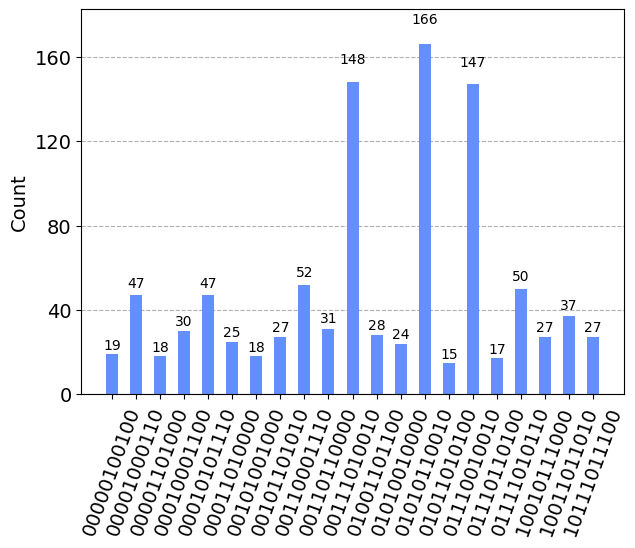

In [201]:
list_numbers = [1,3,5,7,11,13,15]
n = 18
qc, data_quantum, classic_register = find_the_primes_numbers(n, list_numbers, iterations=3)
qc.measure(data_quantum, classic_register)

backend = BasicAer.get_backend('qasm_simulator') # the device to run on

transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, shots=1000).result()
counts  = result.get_counts(qc)
print(counts)   
plot_histogram(counts)

In [215]:
N = int(np.ceil(np.log2(max(list_numbers)))) # number of bits necessary to represent each number in the list
m = len(list_numbers) # number of elements in list
N_m = int(np.ceil(np.log2(m-1))) # number of bits necessary to represent each index in the list (0, 1, ..., m-1)

sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)

for bin_str, val in sorted_counts:
    print(list_numbers[bin_2_int(bin_str[:N_m])], "+", list_numbers[bin_2_int(bin_str[N_m:2*N_m])], "=", bin_2_int(bin_str[-N-1:]), ":", val, "counts")

5 + 13 = 18 : 166 counts
3 + 15 = 18 : 148 counts
7 + 11 = 18 : 147 counts
3 + 11 = 14 : 52 counts
7 + 15 = 22 : 50 counts
1 + 5 = 6 : 47 counts
1 + 13 = 14 : 47 counts
11 + 15 = 26 : 37 counts
3 + 13 = 16 : 31 counts
1 + 11 = 12 : 30 counts
5 + 7 = 12 : 28 counts
3 + 7 = 10 : 27 counts
13 + 15 = 28 : 27 counts
11 + 13 = 24 : 27 counts
1 + 15 = 16 : 25 counts
5 + 11 = 16 : 24 counts
1 + 3 = 4 : 19 counts
1 + 7 = 8 : 18 counts
3 + 5 = 8 : 18 counts
7 + 13 = 20 : 17 counts
5 + 15 = 20 : 15 counts


The pair of integers with higher probability is

In [216]:
best_result = sorted_counts[0][0]
print(list_numbers[bin_2_int(best_result[:N_m])], "+", list_numbers[bin_2_int(best_result[N_m:2*N_m])], "=", bin_2_int(best_result[-N-1:])) 

5 + 13 = 18


Circuit:

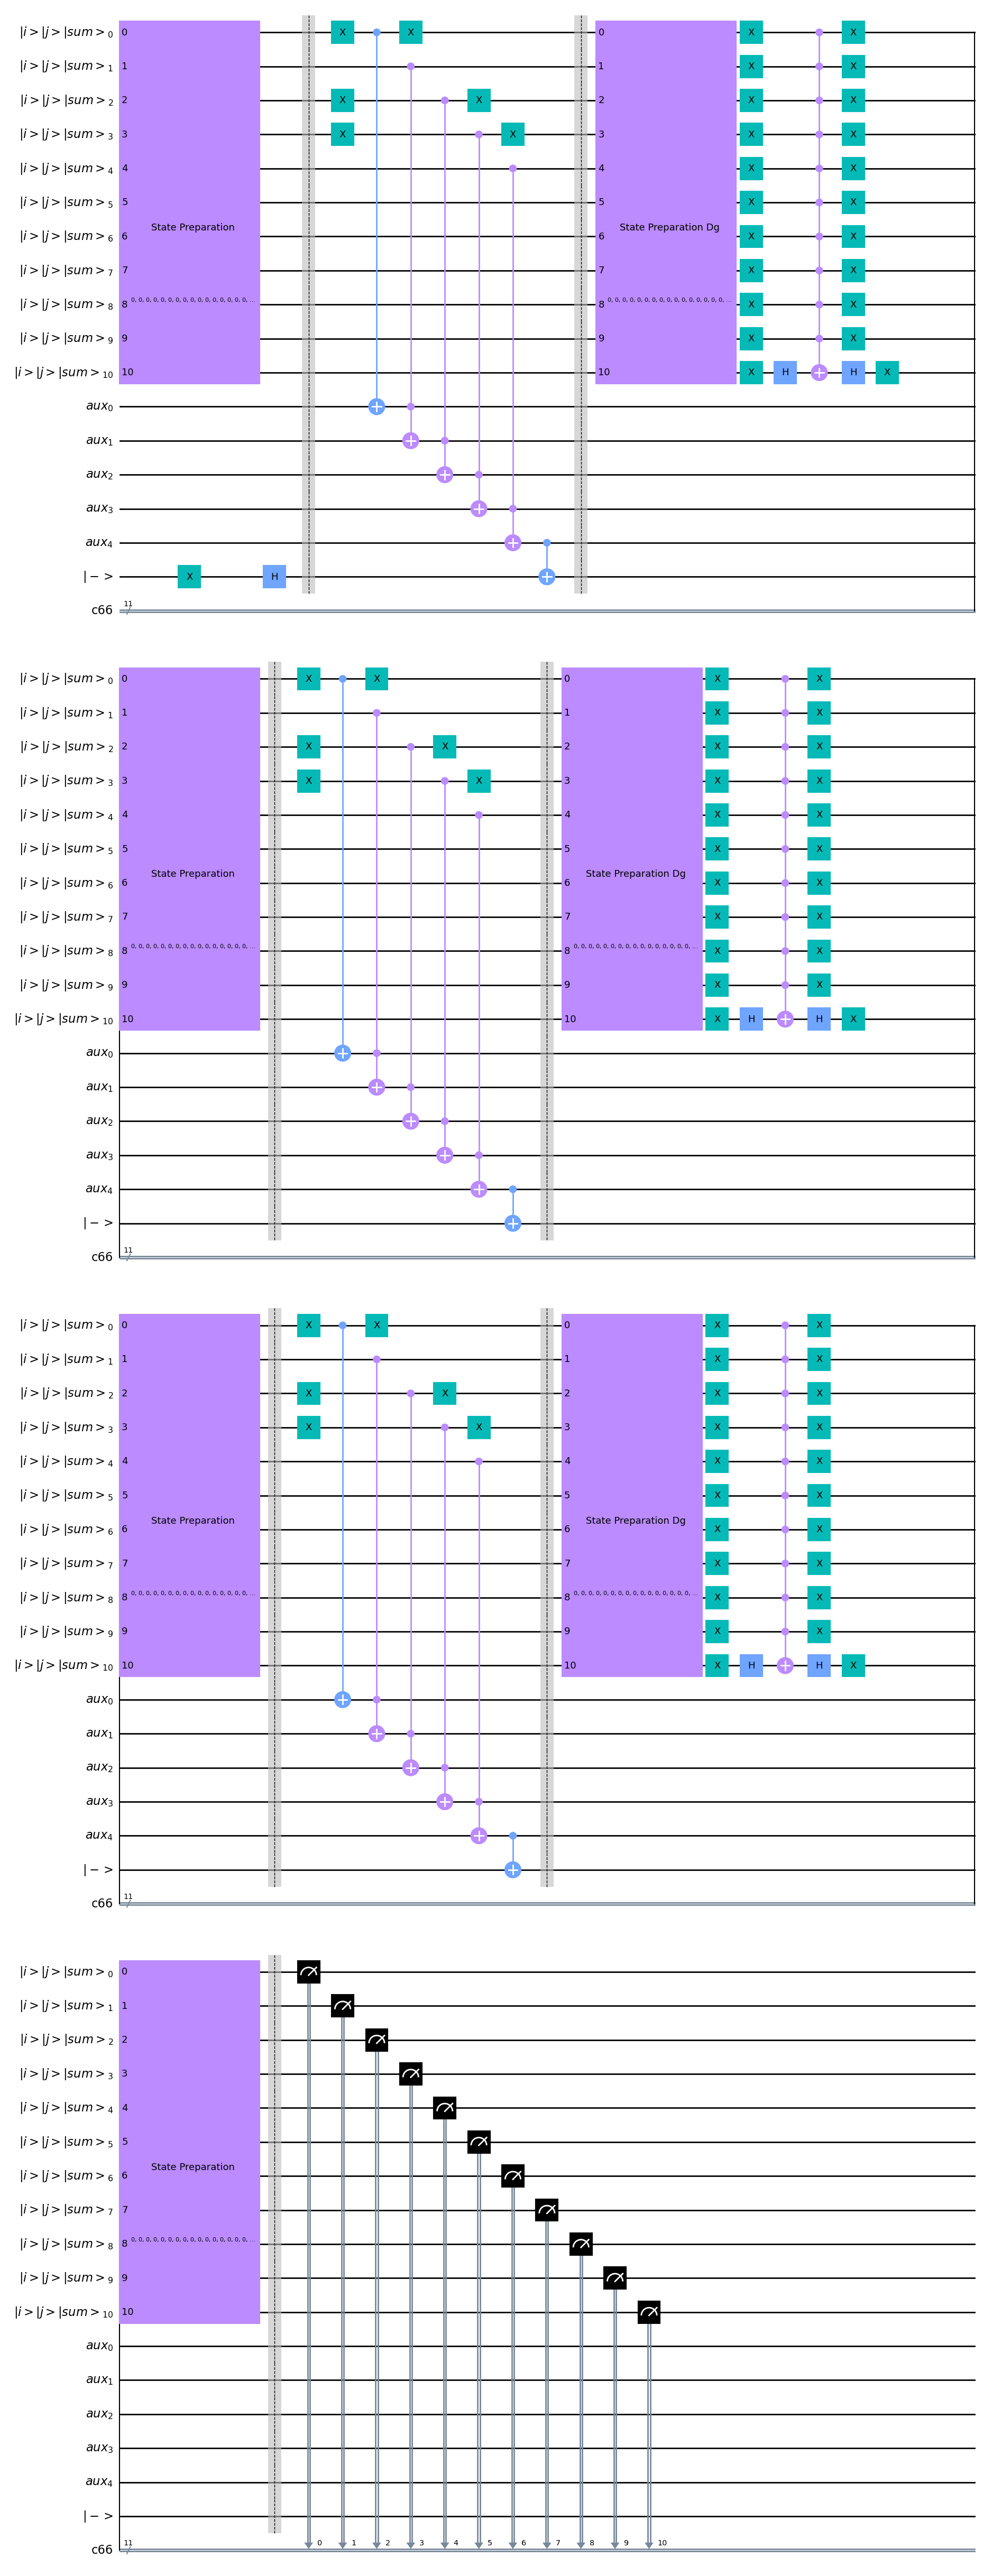

In [197]:
qc.draw(output='mpl')